In [2]:
#import all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
data = r'C:\Users\Shree\Downloads\brain_tumor_dataset'
No_brain_tumor = r'C:\Users\Shree\Downloads\brain_tumor_dataset\no'
Yes_brain_tumor = r'C:\Users\Shree\Downloads\brain_tumor_dataset\yes'

In [4]:
import os

dir_list = [No_brain_tumor, Yes_brain_tumor]
classes = ['No', 'Yes']
filepaths = []
labels = []

for i,j in zip(dir_list, classes):
    filelist = os.listdir(i)
    for name in filelist:
        filepath = os.path.join(i, name)
        filepaths.append(filepath)
        labels.append(j)
        
print('filepaths:', len(filepaths), 'labels:', len(labels))

filepaths: 253 labels: 253


In [5]:
file_content=pd.Series(filepaths, name='filepaths')
label_content=pd.Series(labels, name='labels')
df=pd.concat([file_content,label_content], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,C:\Users\Shree\Downloads\brain_tumor_dataset\n...,No
1,C:\Users\Shree\Downloads\brain_tumor_dataset\n...,No
2,C:\Users\Shree\Downloads\brain_tumor_dataset\n...,No
3,C:\Users\Shree\Downloads\brain_tumor_dataset\n...,No
4,C:\Users\Shree\Downloads\brain_tumor_dataset\n...,No


In [6]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


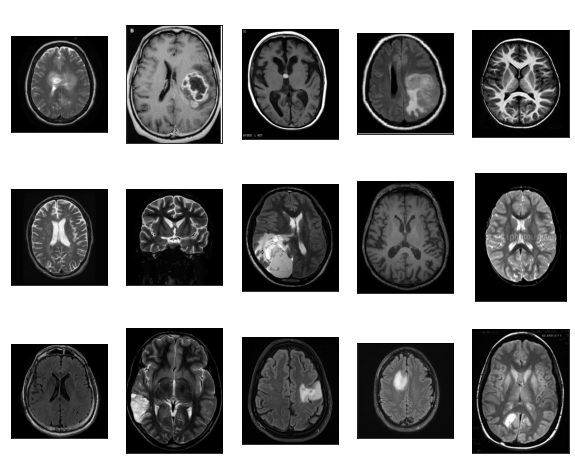

In [7]:
#visualize brain tumor images
import cv2

plt.figure(figsize=(10,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(df, test_size=0.2, random_state=42)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)

print(f"train set shape: {x_train.shape}")
print(f"test set shape: {x_test.shape}")
print(f"validation set shape: {x_val.shape}")

train set shape: (161, 2)
test set shape: (51, 2)
validation set shape: (41, 2)


In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode ='nearest')

validation_datagen = ImageDataGenerator(rescale = 1.0/255.0)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [10]:
train_generator = train_datagen.flow_from_dataframe(dataframe = x_train,
                                                   x_col = 'filepaths',
                                                   y_col = 'labels',
                                                   target_size=(150,150),
                                                   class_mode='binary',
                                                   batch_size=16)

validation_generator = validation_datagen.flow_from_dataframe(dataframe = x_val,
                                                             x_col = 'filepaths',
                                                             y_col = 'labels',
                                                             target_size = (150,150),
                                                             class_mode='binary',
                                                             batch_size=8)

test_generator = test_datagen.flow_from_dataframe(dataframe = x_test,
                                                  x_col = 'filepaths',
                                                  y_col = 'labels',
                                                  target_size = (150,150),
                                                  class_mode='binary',
                                                  batch_size=8)

Found 161 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [11]:
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', 
                                                     input_shape = (150,150,3),
                                                     include_top=False)


model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              14156800  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 68,494,561
Trainable params: 68,434,017
Non-trainable params: 60,544
_________________________________________________________________


In [13]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate = 0.0001), metrics=['accuracy'])

In [14]:
history = model.fit(train_generator,
                   epochs=30,
                   steps_per_epoch=10,
                   validation_data = validation_generator,
                   validation_steps=6,
                   verbose=1)

Epoch 1/30
10/10 [==============================] - 91s 6s/step - loss: 0.6385 - accuracy: 0.6621 - val_loss: 5.8611 - val_accuracy: 0.2683
Epoch 2/30
10/10 [==============================] - 57s 6s/step - loss: 0.7480 - accuracy: 0.6966 - val_loss: 1.2156 - val_accuracy: 0.5854
Epoch 3/30
10/10 [==============================] - 57s 6s/step - loss: 0.6197 - accuracy: 0.7448 - val_loss: 2.0512 - val_accuracy: 0.4878
Epoch 4/30
10/10 [==============================] - 58s 6s/step - loss: 0.5023 - accuracy: 0.7931 - val_loss: 1.2344 - val_accuracy: 0.6585
Epoch 5/30
10/10 [==============================] - 59s 6s/step - loss: 0.2702 - accuracy: 0.8897 - val_loss: 0.4179 - val_accuracy: 0.8537
Epoch 6/30
10/10 [==============================] - 57s 6s/step - loss: 0.2279 - accuracy: 0.9034 - val_loss: 0.7471 - val_accuracy: 0.7805
Epoch 7/30
10/10 [==============================] - 56s 6s/step - loss: 0.2257 - accuracy: 0.8897 - val_loss: 0.5792 - val_accuracy: 0.8049
Epoch 8/30
10/10 [==

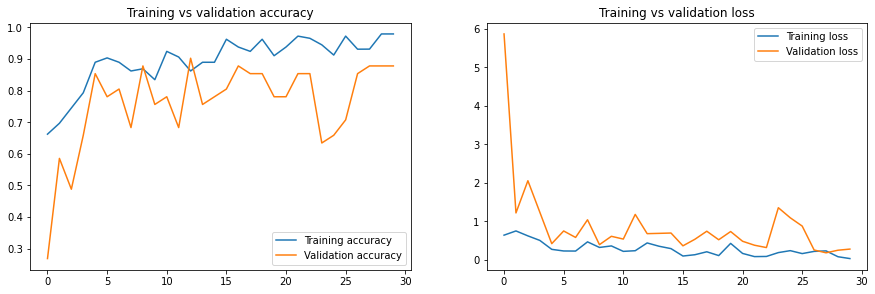

In [15]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [16]:
test_accuracy = model.evaluate(test_generator)[1]

7/7 [==============================] - 4s 525ms/step - loss: 0.5248 - accuracy: 0.9216


In [17]:
print(test_accuracy
     )

0.9215686321258545


In [18]:
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
y_pred = [labels[k] for k in pred]

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
print("\n The Classification report is \n")
print(classification_report(x_test.labels, y_pred))
print("\n The Confusion Matrix is \n")
print(confusion_matrix(x_test.labels, y_pred))


 The Classification report is 

              precision    recall  f1-score   support

          No       0.39      1.00      0.56        20
         Yes       0.00      0.00      0.00        31

    accuracy                           0.39        51
   macro avg       0.20      0.50      0.28        51
weighted avg       0.15      0.39      0.22        51


 The Confusion Matrix is 

[[20  0]
 [31  0]]


C:\Users\Shree\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
